# Shoulder X-ray Classification
![](https://media.istockphoto.com/photos/shoulder-joint-xray-doctor-picture-id1214609679?k=6&m=1214609679&s=612x612&w=0&h=67qLAk-zF167YMee0HHkIQ5WBeicv6ItHGPhkXNHTsI=)

### Contents
1. Abstract
2. Dataset
3. Goal
4. Importing all the required libraries and Dataset
5. EfficientNet Model Deployment
6. Evaluate the model
7. Make Predictions
8. Conclusion

**************************

### Abstract
Total Shoulder Arthroplasty (TSA) is a type of surgery in which the damaged ball of the shoulder is replaced with a prosthesis. Many years later, this prosthesis may be in need of servicing or replacement. In some situations, such as when the patient has changed his country of residence, the model and the manufacturer of the prosthesis may be unknown to the patient and primary doctor. Correct identification of the implant’s model prior to surgery is required for selecting the correct equipment and procedure. We present a novel way to automatically classify shoulder implants in X-ray images. We employ deep learning models and compare their performance to alternative classifiers, such as random forests and gradient boosting. We find that deep convolutional neural networks outperform other classifiers significantly if and only if out-of-domain data such as ImageNet is used to pre-train the models. In a data set containing X-ray images of shoulder implants from 4 manufacturers and 16 different models, deep learning is able to identify the correct manufacturer with an accuracy of approximately 80% in 10-fold cross validation, while other classifiers achieve an accuracy of 56% or less. We believe that this approach will be a useful tool in clinical practice, and is likely applicable to other kinds of prostheses.

### Dataset
The dataset which is used here, is collected from Kaggle website. Here is the link of the dataset : https://www.kaggle.com/dryari5/shoulder-xray-classification.

### Goal
The goal of this project is to create a classification model which will classify different images of shoulder x-ray and predict or, detect the type of the image!
************************

### Importing required libraries and Dataset

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML


### Define function to show images

In [2]:
def show_image_samples(gen ):
    t_dict = gen.class_indices
    classes = list(t_dict.keys())
    images,labels = next(gen) #get sample batch from generator
    plt.figure(figsize=(20, 20))
    length = len(labels)
    if length<25: # show maximum of 25 samples
        r = length
    else:
        r = 25
    for i in range(r):
        plt.subplot(5,5, i+1)
        image=images[i]/255
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color = 'blue', fontsize=16)
        plt.axis('off')
    plt.show()

### Input an image

(1194, 1281, 3)


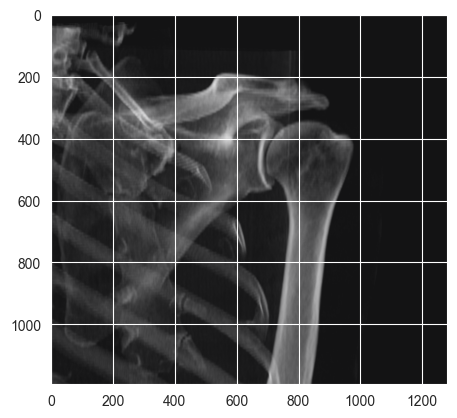

In [3]:
#fpath = r'../input/shoulder-xray-classification/Dataset/test/A1/107zzd+0.png'
fpath= r'C:/Users/NEETHEESWARAN/Git/Shoulder X-ray Clssification/Dataset/test/A1/107zzd+0.png'
img = plt.imread(fpath)
print(img.shape)
imshow(img)

###  Iterate through the data directory and create a data frame of the form filepaths, labels

In [4]:
sdir = r'C:/Users/NEETHEESWARAN/Git/Shoulder X-ray Clssification/Dataset'
categories = ['test', 'train', 'val']
for category in categories:
    category_path = os.path.join(sdir, category)
    filepaths = []
    labels = []
    classlist = os.listdir(category_path)
    for klass in classlist:
        classpath = os.path.join(category_path, klass)
        flist = os.listdir(classpath)
        for f in flist:
            fpath = os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
    Fseries = pd.Series(filepaths, name = 'filepaths')
    Lseries = pd.Series(labels, name='labels')
    if category=='test':
        test_df=pd.concat([Fseries, Lseries], axis=1)
    elif category=='train':
        train_df=pd.concat([Fseries, Lseries], axis=1)
    else:
        valid_df=pd.concat([Fseries, Lseries], axis=1)        

print (train_df.head())
print('train_df length: ', len(train_df), ' test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
print (train_df['labels'].value_counts()) 

                                           filepaths labels
0  C:/Users/NEETHEESWARAN/Git/Shoulder X-ray Clss...     A1
1  C:/Users/NEETHEESWARAN/Git/Shoulder X-ray Clss...     A1
2  C:/Users/NEETHEESWARAN/Git/Shoulder X-ray Clss...     A1
3  C:/Users/NEETHEESWARAN/Git/Shoulder X-ray Clss...     A1
4  C:/Users/NEETHEESWARAN/Git/Shoulder X-ray Clss...     A1
train_df length:  841  test_df length:  104   valid_df length:  104
labels
Others    552
D1        172
C1         60
A1         57
Name: count, dtype: int64


### Observation
This is a very unbalanced data set for df,  limit  maximum number of samples in a class to 172

In [5]:
sample_list=[]
max_size= 172
groups=train_df.groupby('labels')
for label in train_df['labels'].unique():                 
    group=groups.get_group(label)
    sample_count=len(group)    
    if sample_count> max_size:
        samples=group.sample(max_size, replace=False, weights=None, random_state=123, axis=0).reset_index(drop=True)
    else:
        samples=group.sample(frac=1.0, replace=False, random_state=123, axis=0).reset_index(drop=True)
    sample_list.append(samples)
train_df=pd.concat(sample_list, axis=0).reset_index(drop=True)
print (len(train_df))     
print (train_df['labels'].value_counts())     
        

461
labels
Others    172
D1        172
C1         60
A1         57
Name: count, dtype: int64


### To-Do
To balance the dataset we will create augmented images for classes with less than 172 samples, first create directories to hold the augmented images

In [6]:
working_dir=r'C:/Users/NEETHEESWARAN/Git/Shoulder X-ray Clssification'
aug_dir=os.path.join(working_dir, 'aug')
if os.path.isdir(aug_dir):
    shutil.rmtree(aug_dir)
os.mkdir(aug_dir)
for label in train_df['labels'].unique():
    dir_path = os.path.join(aug_dir,label)
    os.mkdir(dir_path)
print(os.listdir(aug_dir))


['A1', 'C1', 'D1', 'Others']


### Create augmented images and store in the aug directories

In [7]:
target=172 # set the target count for each class in df
gen=ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=20, width_shift_range=.2,
                              height_shift_range=.2, zoom_range=.2)
groups=train_df.groupby('labels') # group by class
for label in train_df['labels'].unique():  # for every class               
    group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
    sample_count=len(group)   # determine how many samples there are in this class  
    if sample_count< target: # if the class has less than target number of images
        aug_img_count=0
        delta=target-sample_count  # number of augmented images to create
        target_dir=os.path.join(aug_dir, label)  # define where to write the images    
        aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=(400,400), class_mode=None, batch_size=1,
                                         shuffle=False, save_to_dir=target_dir, save_prefix='aug-',save_format='jpg')
        while aug_img_count<delta:
            images=next(aug_gen)            
            aug_img_count += len(images) 

Found 57 validated image filenames.
Found 60 validated image filenames.


### Create the aux_df then concatenate with df

In [8]:
aug_fpaths=[]
aug_labels=[]
classlist=os.listdir(aug_dir)
for klass in classlist:
    classpath=os.path.join(aug_dir, klass)     
    flist=os.listdir(classpath)    
    for f in flist:        
        fpath=os.path.join(classpath,f)         
        aug_fpaths.append(fpath)
        aug_labels.append(klass)
Fseries=pd.Series(aug_fpaths, name='filepaths')
Lseries=pd.Series(aug_labels, name='labels')
aug_df=pd.concat([Fseries, Lseries], axis=1)
print ('length of aug_df" ', len(aug_df))
train_df=pd.concat([train_df,aug_df], axis=0).reset_index(drop=True)
train_df=train_df.sample(frac=1.0, replace=False, random_state=123, axis=0).reset_index(drop=True)
print ('length of train_df is: ', len(train_df)) 
print (train_df['labels'].value_counts())        

length of aug_df"  227
length of train_df is:  688
labels
C1        172
D1        172
A1        172
Others    172
Name: count, dtype: int64


### Create train, test, valid generators

In [9]:
height=400
width=400
channels=3
batch_size=20
img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
def scalar(img):
    #img=img/127.5-1
    return img 
trgen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
tvgen=ImageDataGenerator(preprocessing_function=scalar)
sdir=r'Downloads/images'
train_gen=trgen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen=tvgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)
valid_gen=tvgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
classes=list(train_gen.class_indices.keys())
class_count=len(classes)
train_steps=int(len(train_gen.labels)/batch_size)

test batch size:  52   test steps:  2
Found 688 validated image filenames belonging to 4 classes.
Found 104 validated image filenames belonging to 4 classes.
Found 104 validated image filenames belonging to 4 classes.


### Data Visualisation
Creating an sug generator and view some of the augmented images

Found 227 validated image filenames belonging to 2 classes.


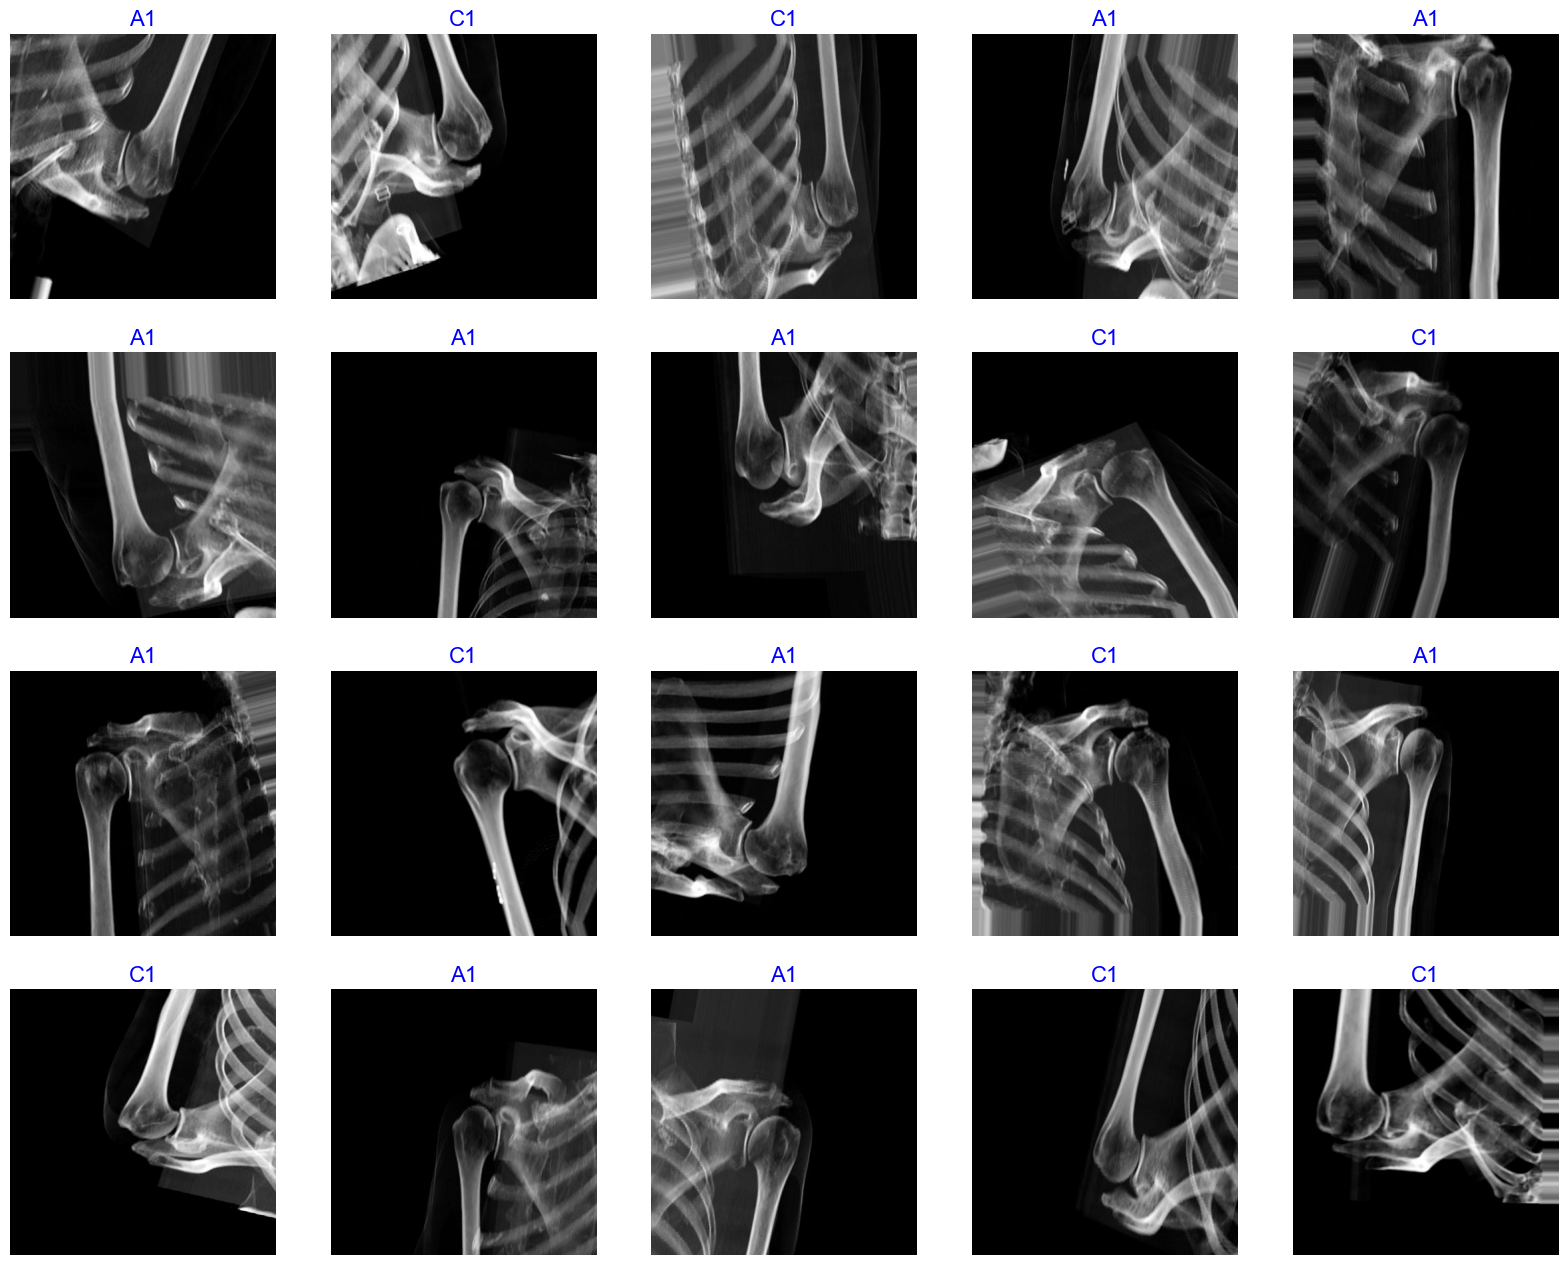

In [10]:
aug_gen=tvgen.flow_from_dataframe( aug_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
show_image_samples(aug_gen)

### Training Images samples

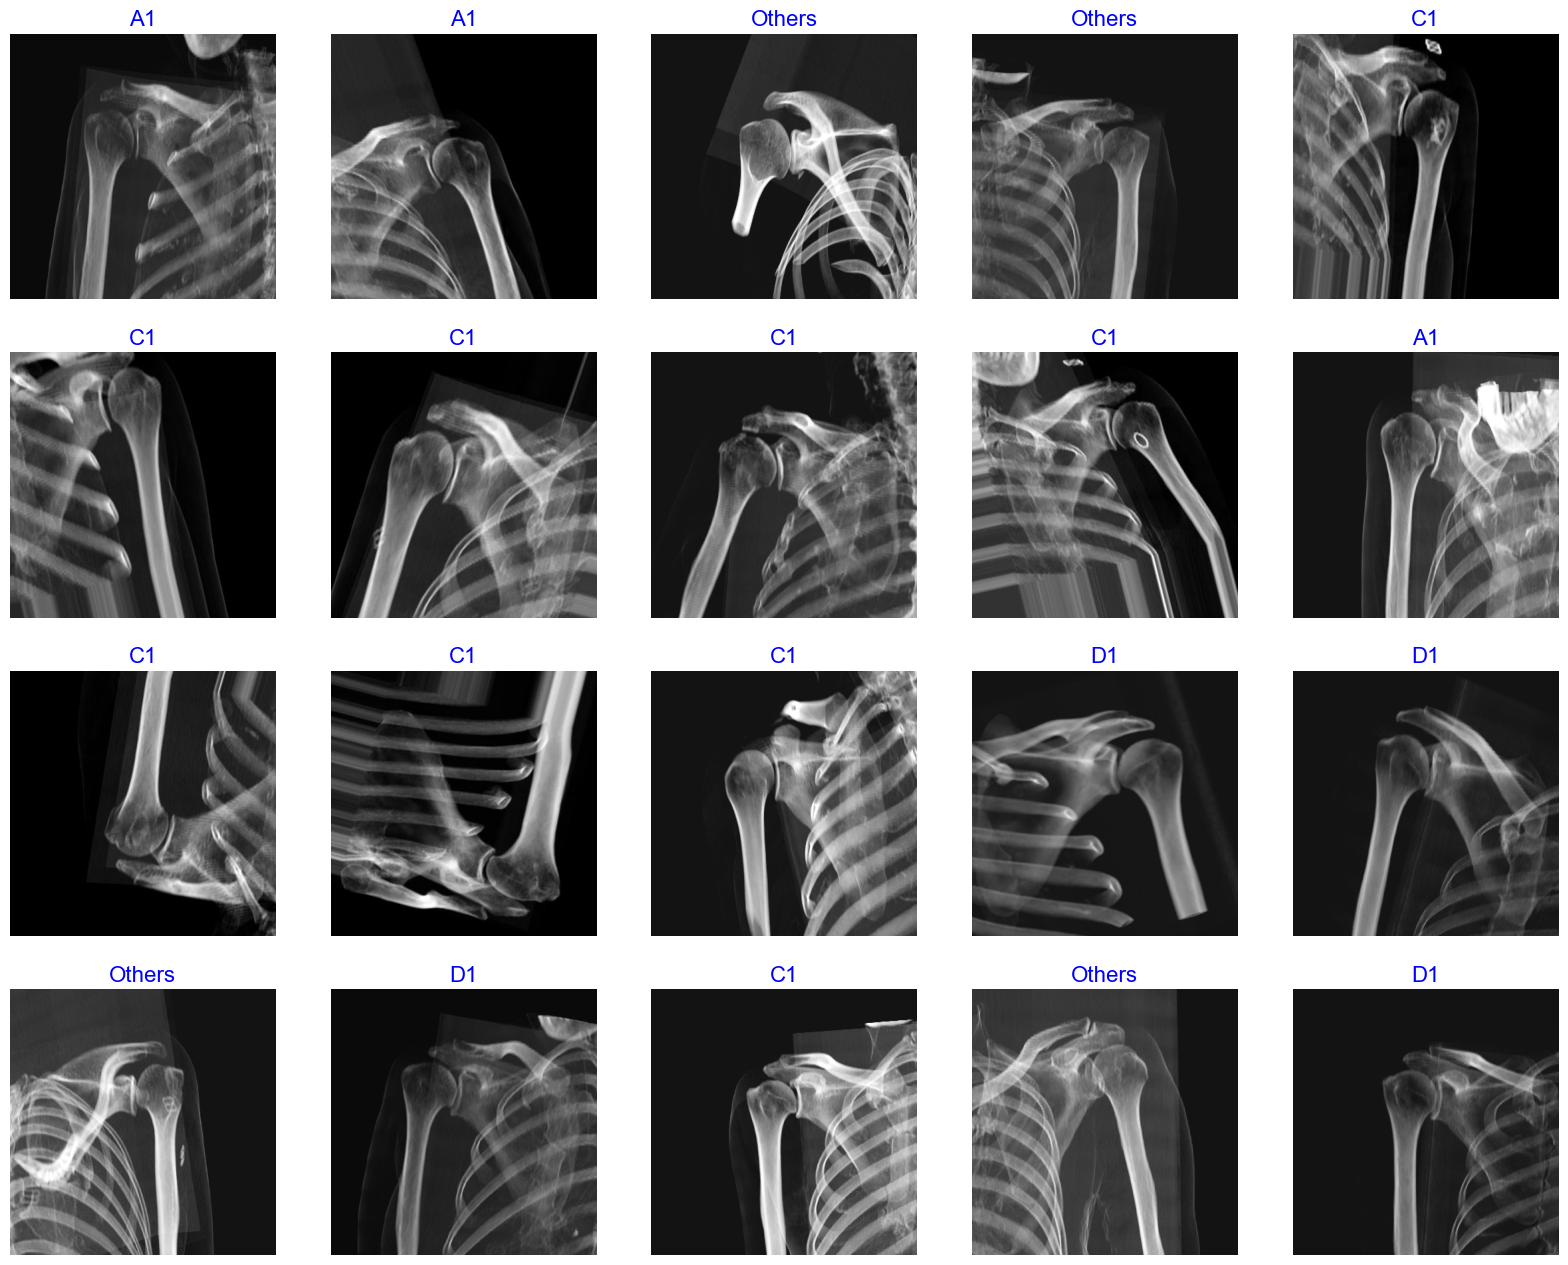

In [11]:
show_image_samples(train_gen)

### Define function to print text in RGB foreground and background colors

In [12]:
def print_in_color(txt_msg, fore_tupple, back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bg = fore_tupple
    rb,gb,bb = back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg. format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color back to black
    return